Titanic Survivals Classification Model

#### VARIABLE DESCRIPTION:


* pclass: Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
* survival: A Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target
* name: A field rich in information as it contains title and family names
* sex: male/female
* age: Age, asignificant portion of values are missing
* sibsp: Number of siblings/spouses aboard
* parch: Number of parents/children aboard
* ticket: Ticket number.
* fare: Passenger fare (British Pound).
* cabin: Doesthe location of the cabin influence chances of survival?
* embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat: Lifeboat, many missing values
* body: Body Identification Number
* home.dest: Home/destination

### NOTES:


1. Pclass is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

2. Age is in Years; Fractional if Age less than One (1).If the Age is Estimated, it is in the form xx.5

3. With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

* Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
* Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
* Parent:   Mother or Father of Passenger Aboard Titanic
* Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

4. Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV




from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,auc,precision_score,recall_score,f1_score
sns.set()
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)





In [2]:
#2.load the dataset
df = pd.read_csv(r"C:\Users\KKapaj\Downloads\titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Finding for columns Sex, Survived, Pclass, SibSp, how many unique values they have

for cat in ['Sex', 'Survived', 'Pclass', 'SibSp', 'Embarked']:
    print(f"Unique values for list of the above columns:{cat,df[cat].unique()}")

Unique values for list of the above columns:('Sex', array(['male', 'female'], dtype=object))
Unique values for list of the above columns:('Survived', array([0, 1], dtype=int64))
Unique values for list of the above columns:('Pclass', array([3, 1, 2], dtype=int64))
Unique values for list of the above columns:('SibSp', array([1, 0, 3, 4, 2, 5, 8], dtype=int64))
Unique values for list of the above columns:('Embarked', array(['S', 'C', 'Q', nan], dtype=object))


In [6]:
# Handing Missing values.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Fill out the missing values for each column that has missing.

# The missing values of Age filled with the mean value.
# The values of Embarked colum map it with 'C':1, 'Q':2,'S':3 and fill out the missing with number 3.
# The missing values of Cabin fill it with "U0".

<AxesSubplot:xlabel='Age', ylabel='Count'>

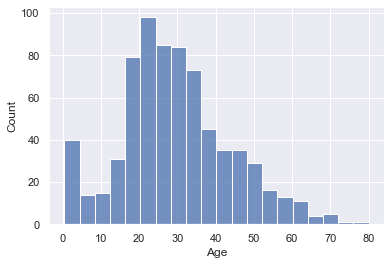

In [27]:
sns.histplot(df['Age'])

In [8]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df.Age.isnull().sum()

0

In [9]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
df['Embarked'] = df['Embarked'].map({'C':1, 'Q':2,'S':3,np.nan:3}).astype(int)
df['Embarked'].isnull().sum()

0

In [11]:
df['Cabin'] = df['Cabin'].fillna("U0")
df['Cabin'].isna().sum()

0

In [13]:
# Showing Survived by Pclass in a tabular format

df.groupby('Pclass').Survived.value_counts()

#.unstack()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

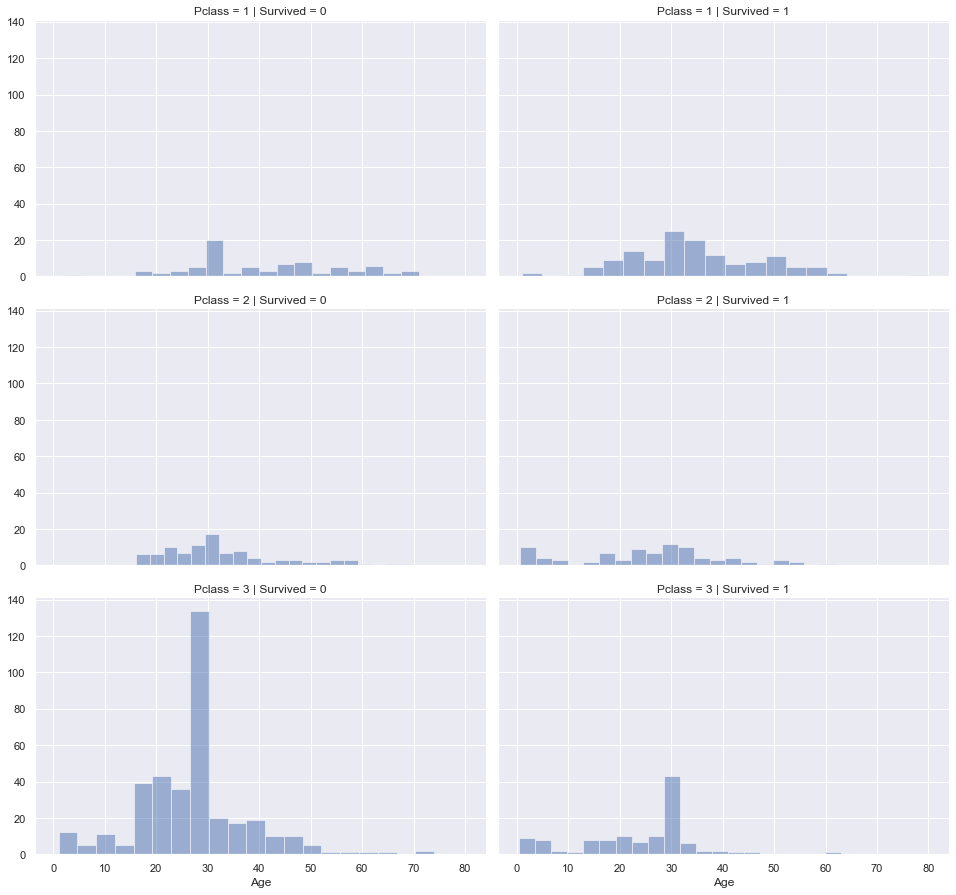

In [33]:
# Show Survived by socio-economic status in a Visualization form. Figuring which ages correspond the survival by socio-economic status.
# Write in your notebook the interpretation from the graph.

grid = sns.FacetGrid(df, col='Survived', row='Pclass',height=4.2,aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)

In [34]:
# Show Survived by Pclass & Sex in a tabular form

df.groupby(['Pclass','Sex']).Survived.value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

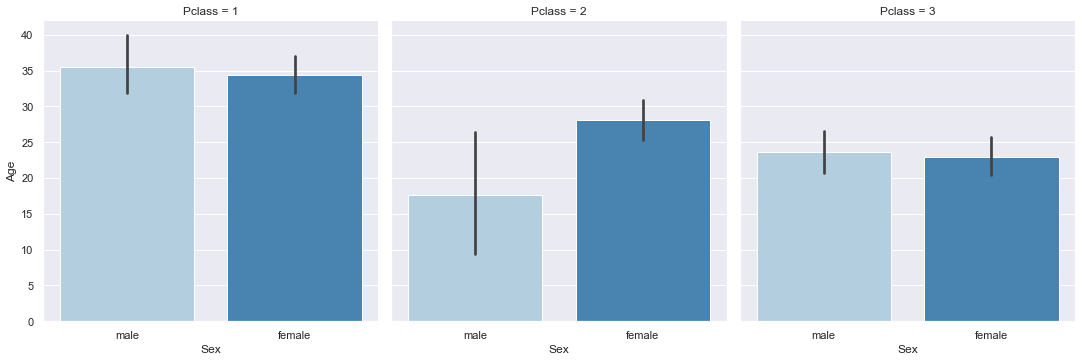

In [35]:
# Show Survived Females and Males by age in graphcal representation

survived_males = df[(df['Sex']=='male')&(df['Survived']==1)]
survived_females = df[(df['Sex']=='female')&(df['Survived']==1)]
survived = pd.concat([survived_males, survived_females])


sns.catplot(x='Sex', y='Age', col='Pclass',data=survived, kind='bar', height=5, palette="Blues")
plt.show()

In [36]:
# Creating a new feature called FamilySize which is the sum of SibSp and Parch features
# Creating a new feature called Age*Class from the multiplication of Age and Pclass feature.

df['FamilySize'] = df.SibSp + df.Parch
df['Age*Class'] = df.Age * df.Pclass
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age*Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,U0,3,1,66.000000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,1,1,38.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,U0,3,0,78.000000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,3,1,35.000000
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,U0,3,0,105.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,U0,3,0,54.000000
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,3,0,19.000000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,U0,3,3,89.097353
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,1,0,26.000000


In [37]:
# Checking the data types of your columns 
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked         int32
FamilySize       int64
Age*Class      float64
dtype: object

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

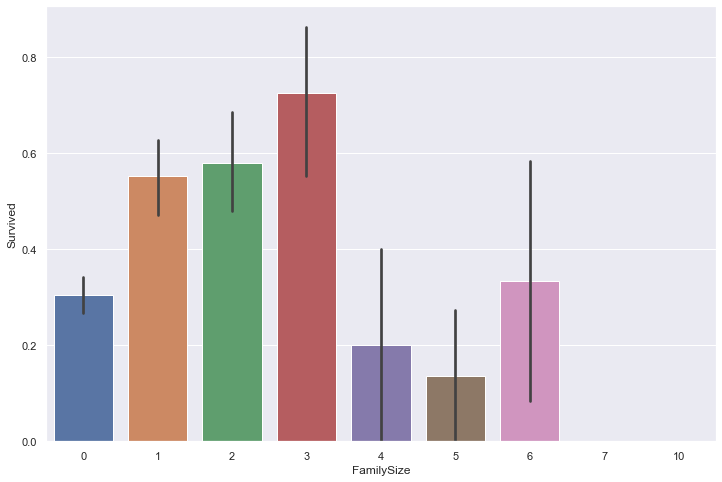

In [38]:
# Does it have any relationship between FamilySize and Survived people?

plt.figure(figsize=(12,8))
sns.barplot(x=df['FamilySize'], y=df['Survived'], data=df)


In [39]:
# Distribution between Embarked and Survided in a tabular format.

df.groupby(['Embarked']).Survived.value_counts()

Embarked  Survived
1         1            93
          0            75
2         0            47
          1            30
3         0           427
          1           219
Name: Survived, dtype: int64

In [40]:
# The average mean of the Fare ticket according to Port of embarkation

df.groupby(['Embarked']).Fare.mean()

Embarked
1    59.954144
2    13.276030
3    27.243651
Name: Fare, dtype: float64

In [41]:
# Encoding the "Sex" field. Female -> 0 , Male ->1.

df['Gender'] = df['Sex'].map({'female': 0, 'male': 1} ).astype(int)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age*Class,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,U0,3,1,66.000000,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,1,1,38.000000,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,U0,3,0,78.000000,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,3,1,35.000000,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,U0,3,0,105.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,U0,3,0,54.000000,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,3,0,19.000000,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,U0,3,3,89.097353,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,1,0,26.000000,1


In [42]:
# Applying one Hot Encoding to Embarked Column.
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

embarked = pd.DataFrame(lb.fit_transform(df['Embarked'].values), columns=['Emb1','Emb2','Emb3'])
df = pd.concat([df, embarked], axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age*Class,Gender,Emb1,Emb2,Emb3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,U0,3,1,66.000000,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,1,1,38.000000,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,U0,3,0,78.000000,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,3,1,35.000000,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,U0,3,0,105.000000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,U0,3,0,54.000000,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,3,0,19.000000,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,U0,3,3,89.097353,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,1,0,26.000000,1,1,0,0


In [43]:
# Transforming the Column Cabin by taking the first Letter out of it ; eg: C85 ->C
import re
df['Cabin'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age*Class,Gender,Emb1,Emb2,Emb3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,U,3,1,66.000000,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,1,1,38.000000,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,U,3,0,78.000000,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C,3,1,35.000000,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,U,3,0,105.000000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,U,3,0,54.000000,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B,3,0,19.000000,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,U,3,3,89.097353,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,1,0,26.000000,1,1,0,0


In [44]:
# Maping the column Cabin as: "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8. 
# Making sure that the column Cabin does not have missing values and it is integer type.
# If missing values, fill it with zeros.

cabin = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

df['Cabin'] = df['Cabin'].map(cabin)
print(df['Cabin'].isnull().sum())
print(" ")
print(df['Cabin'].dtype)

1
 
float64


In [47]:
df['Cabin'] = df['Cabin'].fillna(0)
df['Cabin'] = df['Cabin'].astype(int)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age*Class,Gender,Emb1,Emb2,Emb3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,8,3,1,66.000000,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,3,1,1,38.000000,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,8,3,0,78.000000,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,3,3,1,35.000000,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,8,3,0,105.000000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,8,3,0,54.000000,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,2,3,0,19.000000,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,8,3,3,89.097353,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,3,1,0,26.000000,1,1,0,0


In [48]:
# Form a new df by Excluding from the dataset the column 'PassengerId','Age','Name', 'Sex', 'Ticket', 'Embarked'

In [49]:
df2 = df.loc[:,~df.columns.isin(['PassengerId','Age','Name', 'Sex', 'Ticket', 'Embarked'])]
df2

,Survived,Pclass,SibSp,Parch,Fare,Cabin,FamilySize,Age*Class,Gender,Emb1,Emb2,Emb3
0,0,3,1,0,7.2500,8,1,66.000000,1,0,0,1
1,1,1,1,0,71.2833,3,1,38.000000,0,1,0,0
2,1,3,0,0,7.9250,8,0,78.000000,0,0,0,1
3,1,1,1,0,53.1000,3,1,35.000000,0,0,0,1
4,0,3,0,0,8.0500,8,0,105.000000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,13.0000,8,0,54.000000,1,0,0,1
887,1,1,0,0,30.0000,2,0,19.000000,0,0,0,1
888,0,3,1,2,23.4500,8,3,89.097353,0,0,0,1
889,1,1,0,0,30.0000,3,0,26.000000,1,1,0,0


In [50]:
# Defining x and y for Modeling

x = df2.loc[:,~df2.columns.isin(['Survived'])]

y = df2.loc[:, 'Survived']

In [51]:
# Making Train-Test-Split between x and y happen.

X_train,X_test,y_train,y_test = train_test_split(x,y, random_state = 0, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

In [53]:
# Standardizing Train and Test

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


x_train_scaled=scaler.fit_transform(X_train)
x_test_scaled=scaler.fit_transform(X_test)

#### LOGISTIC REGRESSION WITH HYPERPARAMS:

In [35]:
# Trying LogisticRegression Machine Learning Model with WithHyperparameter tunning.Try different hyperparameters to tune

model_lr = LogisticRegression()

regularization_values = ['l1','l2']
solver_values = ['saga','liblinear'] # Stochastic Average Gradient Descent

param_grid_lr = dict(penalty = regularization_values, solver = solver_values) #{'penalty': ['l1', 'l2'], 'solver': ['saga', 'liblinear']}

grid_lr = GridSearchCV(estimator = model_lr, param_grid = param_grid_lr, scoring = None) #scoring = None => default "accuracy"

grid_result_lr = grid_lr.fit(x_train_scaled, y_train)

print("The best parameters are:", grid_result_lr.best_params_ ,"The best score are:", grid_result_lr.best_score_)
 

The best parameters are: {'penalty': 'l1', 'solver': 'saga'} The best score are: 0.7907416527134836


In [36]:
classifier_logistics = LogisticRegression(solver ='saga' ,#grid_result_lr.best_estimator_.solver
                                            penalty = 'l1',#grid_result_lr.best_estimator_.penalty
                                            fit_intercept = True,
                                             ).fit(x_train_scaled, y_train)



y_pred_train_logistics = classifier_logistics.predict(x_train_scaled)

y_pred_test_logistics = classifier_logistics.predict(x_test_scaled)



print("Test accuracy:{}".format(accuracy_score(y_test, y_pred_test_logistics.round())))
print("Train accuracy:{}".format(accuracy_score(y_train, y_pred_train_logistics.round())))
print(" ") 

print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred_test_logistics))


print(" ")

print("Classification Report:")
print(classification_report(y_test,y_pred_test_logistics))

print(" ")



Test accuracy:0.8100558659217877
Train accuracy:0.797752808988764
 
Confusion Matrix:
[[98 12]
 [22 47]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

 


#### KNN WITH HYPERPARAMS:

In [37]:
# Trying KNN Machine Learning Model with WithHyperparameter tunning.Try different hyperparameters to tune.

model_kneighbors = KNeighborsClassifier()

neighbors_values = [4,5,6,7]
p_values = [1,2] #p=1 manhattan distance, p=2 euclidean distance


param_grid_kn = dict(n_neighbors = neighbors_values, p = p_values)

grid_kn = GridSearchCV(estimator = model_kneighbors, param_grid = param_grid_kn, scoring = None)#scoring = None => default "accuracy"

grid_result_kn = grid_kn.fit(x_train_scaled,y_train)

print("The best parameters are:", grid_result_kn.best_params_ ,"The best score is:", grid_result_kn.best_score_)

The best parameters are: {'n_neighbors': 6, 'p': 2} The best score is: 0.8061558160149709


In [39]:
classifier_kneighbors = KNeighborsClassifier(n_neighbors = 6 ,#grid_result_kn.best_estimator_.n_neighbors,grid_result_kn.best_estimator_.p
                                             p = 2).fit(x_train_scaled, y_train)



y_pred_train_kneighbors = classifier_kneighbors.predict(x_train_scaled)

y_pred_test_kneighbors = classifier_kneighbors.predict(x_test_scaled)



print("Test accuracy:{}".format(accuracy_score(y_test, y_pred_test_kneighbors.round())))
print("Train accuracy:{}".format(accuracy_score(y_train, y_pred_train_kneighbors.round())))
print(" ") 

print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred_test_kneighbors))


print(" ")

print("Classification Report:")
print(classification_report(y_test,y_pred_test_kneighbors))

print(" ")

Test accuracy:0.7988826815642458
Train accuracy:0.8455056179775281
 
Confusion Matrix:
[[99 11]
 [25 44]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.64      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

 
